### Orchestration
#### ELI5 n topics

In [1]:
from langchain_ollama import ChatOllama

llm_model = ChatOllama(model="llama3.1:latest")

E:\agenticai\venv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from typing_extensions import List
from pydantic import BaseModel, Field


class Topic(BaseModel):
    title: str = Field(
        description="Title of the topic"
    )


class Topics(BaseModel): # used by planner only
    topics: List[Topic] = Field(
        description="Topics generated by the trivia model"
    )

planner=llm_model.with_structured_output(Topics)

In [3]:
import operator
from typing_extensions import TypedDict, Annotated


class State(TypedDict):
    topics: list[Topic]  # List of report sections
    eli5: Annotated[
        list, operator.add
    ]
    combiner: str

class WorkerState(TypedDict):
    title: str  # List of report sections
    # eli5: Annotated[list, operator.add]


In [4]:
from langgraph.constants import Send
from langchain_core.messages import SystemMessage


def orchestrator(state: State):
    print("=================orchestrator=======================")
    print(state)
    result = planner.invoke("Generate a list of 3 topics in STEM fields")
    print(result)
    return {"topics": result.topics}

def llm_assigner(state: State):
    print("=================llm_assigner=======================")
    print(state)
    result = [Send("llm_worker", {"title": s.title}) for s in state["topics"]]
    print(result)
    return result

def llm_worker(state: WorkerState):
    print("=================llm_worker=======================")
    print(state)
    result = llm_model.invoke(f"Generate a small ELI5 explanation on this topic: {state['title']}")
    print(result)
    return {"eli5": [result.content]}

def combiner(state: State):
    print("=================combiner=======================")

    system_state = "\n\n---\n\n".join(state['eli5'])

    print(state)
    return {"combiner": system_state}

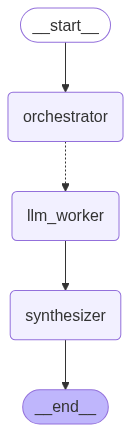

In [5]:
# from langgraph.constants import START
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_node("orchestrator",orchestrator)
# graph_builder.add_node("llm_assigner",llm_assigner)
graph_builder.add_node("llm_worker",llm_worker)
graph_builder.add_node("synthesizer",combiner)

graph_builder.add_edge(START,"orchestrator")
graph_builder.add_conditional_edges("orchestrator",llm_assigner,["llm_worker"])
graph_builder.add_edge("llm_worker","synthesizer")
graph_builder.add_edge("synthesizer",END)
graph = graph_builder.compile()
graph


In [6]:


res = graph.invoke({})

res

=================orchestrator=======================
{'eli5': []}
topics=[Topic(title='Synthetic Biology: Designing New Biological Systems'), Topic(title='Quantum Computing: Harnessing the Power of Quantum Mechanics'), Topic(title='Materials Science: Developing New Materials with Unique Properties')]
=================llm_assigner=======================
{'topics': [Topic(title='Synthetic Biology: Designing New Biological Systems'), Topic(title='Quantum Computing: Harnessing the Power of Quantum Mechanics'), Topic(title='Materials Science: Developing New Materials with Unique Properties')], 'eli5': []}
[Send(node='llm_worker', arg={'title': 'Synthetic Biology: Designing New Biological Systems'}), Send(node='llm_worker', arg={'title': 'Quantum Computing: Harnessing the Power of Quantum Mechanics'}), Send(node='llm_worker', arg={'title': 'Materials Science: Developing New Materials with Unique Properties'})]
=================llm_worker=======================
{'title': 'Synthetic Biology: D

{'topics': [Topic(title='Synthetic Biology: Designing New Biological Systems'),
  Topic(title='Quantum Computing: Harnessing the Power of Quantum Mechanics'),
  Topic(title='Materials Science: Developing New Materials with Unique Properties')],
 'eli5': ['Here\'s an ELI5 (Explain Like I\'m 5) explanation of Synthetic Biology:\n\n**Imagine You\'re a Lego Master Builder**\n\nYou love building new things with Legos, but now imagine you can design your own special kind of Lego brick that doesn\'t exist yet. You could create bricks that glow in the dark, or ones that change color when you touch them.\n\nSynthetic biology is similar to being a Lego master builder for living cells. Instead of blocks and bricks, scientists are designing new biological systems using DNA, proteins, and other tiny building blocks called genes.\n\n**What Does It Mean to "Design" a New Biological System?**\n\nIn simple terms, synthetic biologists use computer tools to design and build new biological pathways, or se

In [8]:
from IPython.display import Markdown
Markdown(res["combiner"])

Here's an ELI5 (Explain Like I'm 5) explanation of Synthetic Biology:

**Imagine You're a Lego Master Builder**

You love building new things with Legos, but now imagine you can design your own special kind of Lego brick that doesn't exist yet. You could create bricks that glow in the dark, or ones that change color when you touch them.

Synthetic biology is similar to being a Lego master builder for living cells. Instead of blocks and bricks, scientists are designing new biological systems using DNA, proteins, and other tiny building blocks called genes.

**What Does It Mean to "Design" a New Biological System?**

In simple terms, synthetic biologists use computer tools to design and build new biological pathways, or series of steps, that can be used by living cells. They might create a new way for a cell to make a particular chemical, or even invent a brand new organism!

**Why Do We Need Synthetic Biology?**

Right now, scientists are trying to solve many big problems like:

* How to cure diseases
* How to grow food more efficiently and sustainably
* How to clean up pollution

Synthetic biology helps us tackle these challenges by creating new biological systems that can make our lives better. It's like having a superpower in the lab!

**So, What's the Big Deal?**

Synthetic biology is exciting because it allows scientists to invent new things that don't exist in nature. This means we can create solutions to real-world problems in a more efficient and sustainable way.

But remember, synthetic biologists are still careful and responsible when designing new biological systems. They make sure they're safe for humans, animals, and the environment before unleashing them on the world!

---

Here's an ELI5 (Explain Like I'm 5) explanation of Quantum Computing:

**Imagine You Have a Toy Box**

In a regular computer, information is like toys in a toy box. Each toy represents a piece of info, and we can take one out at a time to use or look at it. But what if you had a special toy box that could hold an infinite number of toys, all jumbled together? That's kind of like how Quantum Computing works.

**Quantum Mechanics: The Secret Sauce**

Regular computers use something called "bits" to store information, but Quantum Computers use something called "qubits" (quantum bits). Qubits are special because they can hold many different pieces of info at the same time! It's like each toy in the box can be all colors and shapes simultaneously. This means a Quantum Computer can do many calculations **at once**, making it incredibly fast.

**Think of it Like Guessing a Secret Code**

Imagine you have a combination lock with 10 numbers. A regular computer would try each number one by one to find the correct code. But a Quantum Computer is like having a friend who can guess all 1,000 possible combinations simultaneously! This means it can crack secret codes much faster and solve problems that would take a regular computer years to solve.

**Harnessing the Power**

By harnessing the power of Quantum Mechanics, we can create computers that are not only super fast but also incredibly good at solving complex problems. These computers have the potential to revolutionize fields like medicine, finance, and science, helping us find new cures for diseases, optimize global systems, and explore space.

That's a basic idea of what Quantum Computing is all about!

---

Here's an ELI5 (Explain Like I'm 5) explanation:

**Imagine You're Building a LEGO Castle**

You know how you can build different things with LEGO blocks, like a castle or a car? Well, scientists in the field of Materials Science are like master builders who create new kinds of building blocks called "materials". These materials have special properties that make them super useful for all sorts of things.

**What's wrong with regular materials?**

The materials we use every day, like wood, metal, and plastic, are great, but they can be a bit... ordinary. They might get too heavy or too brittle (break easily). Scientists want to create new materials that have special powers, like:

* Being super strong but also super light
* Being able to store energy like batteries
* Being able to change color when it gets hot or cold
* Being able to heal itself if it gets damaged

**How do they make these magic materials?**

Scientists use powerful tools and computers to "design" new materials from scratch. They try out different combinations of atoms (the tiny building blocks of everything around us) to create a material with the desired properties.

For example, imagine creating a material that's as strong as steel but also flexible like rubber. Scientists would mix and match different types of atoms until they get just the right combination. Then, they test it to see if it works!

**The possibilities are endless!**

When scientists succeed in making new materials with special properties, they can create all sorts of amazing things:

* Super-strong buildings that can withstand earthquakes
* Energy-saving windows that keep your home cozy and warm
* Self-healing surfaces for ships and planes

Who knows what amazing materials we'll come up with next? The world of Materials Science is like building a never-ending LEGO castle, where the possibilities are endless!